In [1]:
import re, pprint, os, numpy,string
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics.cluster import *
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from deep_translator import GoogleTranslator
from langdetect import detect
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i100v\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Fuctions from SOTO

In [2]:
def read_files(path):
    print("Reading files...")
    listing = os.listdir(folder)
    texts=[]
    for file in listing:
        if file.endswith(".txt"):
            url = folder+"/"+file
            f = open(url,encoding="latin-1");
            raw = f.read()
            f.close()
            texts.append(raw)
    return texts

def cluster_texts(texts, clustersNumber, distance):
    #Load the list of texts into a TextCollection object.
    collection = nltk.TextCollection(texts)
    print("Created a collection of", len(collection), "terms.")

    #get a list of unique terms
    unique_terms = list(set(collection))
    print("Unique terms found: ", len(unique_terms))

    ### And here we actually call the function and create our array of vectors.
    vectors = [numpy.array(TF(f,unique_terms, collection)) for f in texts]
    print("Vectors created.")

    # initialize the clusterer
    clusterer = AgglomerativeClustering(n_clusters=clustersNumber,
                                      linkage="average", affinity=distanceFunction)
    clusters = clusterer.fit_predict(vectors)

    return clusters

# Function to create a TF vector for one document. For each of
# our unique words, we have a feature which is the tf for that word
# in the current document
def TF(document, unique_terms, collection):
    word_tf = []
    for word in unique_terms:
        word_tf.append(collection.tf(word, document))
    return word_tf

# Our fuctions

In [3]:
def  first_rude_clean_text(texts):
    for txt in range(len(texts)):
        texts[txt] = texts[txt].lower()
        texts[txt]=re.sub('<.*?>', '', texts[txt])
        texts[txt] = re.sub("\n","",texts[txt])
        texts[txt] = re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", texts[txt]) 
        
    return texts
        
def translate_texts(texts):
    print("Translating...")
    for txt in range(len(texts)):
        if detect(texts[txt])=='es':
            if(len(texts[txt])>4000):
                chunks, chunk_size = len(texts[txt])//4000, 4000
                chunks_txt= [ texts[txt][i:i+chunk_size] for i in range(0, chunks, chunk_size) ]
                for j in range(len(chunks_txt)):
                    chunks_txt[j] = GoogleTranslator(source='es', target='en').translate(chunks_txt[j])
                texts[txt]=''.join(chunks_txt)
            else:
                texts[txt]=GoogleTranslator(source='es', target='en').translate(texts[txt])
    return texts
    
def tokenize_texts(texts):
    for txt in range(len(texts)):
        texts[txt]=word_tokenize(texts[txt])
    return texts  

def clean_stop_words_punct (texts):
    stop = stopwords.words('english')
    punct = list(string.punctuation)
    for txt_tok in range(len(texts)):
        texts[txt_tok] = [w for w in texts[txt_tok] if w not in (stop) and w not in (punct) ]
    return texts

def first_processing(texts):
    texts=first_rude_clean_text(texts)
    texts=translate_texts(texts)
    texts=tokenize_texts(texts)
    texts=clean_stop_words_punct(texts)
    return texts
       
def stemmer_text(texts):
    stemmer = SnowballStemmer("english")
    for txt_tok in range(len(texts)):
        texts[txt_tok] = [stemmer.stem(t) for t in texts[txt_tok]]
    return texts
        
def lemman_text(texts):
    for txt_tok in range(len(texts)):
        texts[txt_tok] = [WordNetLemmatizer().lemmatize(w) for w in texts[txt_tok]]
    return texts

def get_term_matrix(texts):
    total_w=set()
    for txt in texts:
        for w in txt:
            total_w.add(w)
    total_words=list(total_w)
    table=[]
    for text in texts:
        row=np.zeros(len(total_words))
        for word in text:
            index=total_words.index(word)
            row[index]+=1
        table.append(row)
    df=pd.DataFrame(table)
    df.columns=total_words
    return df
            
            

In [4]:
folder = "../data/"
texts=read_files(folder)
texts=first_processing(texts)

Reading files...
Translating...


In [5]:
texts=stemmer_text(texts)

df_texts=get_term_matrix(texts)

Reading files...
Translating...
[[-0.17346    -0.13813741]
 [-0.09683331 -0.25045163]
 [-0.09934579 -0.20614777]
 [ 0.55532341  0.11927002]
 [-0.38461434  0.66952277]
 [-0.18054292 -0.34278157]
 [-0.17704571  0.11325204]]
0 saudi releas activist loujain right women alhathloul prison arabia sister sentenc hathloul famili al saud 
1 trump border emerg wall biden fund declar presid construct congress cancel letter order allow use 
2 guard coast island rescu citizen cuban florida patrol feed center key servic us surviv three 
3 ecuador vote yaku lasso second elector prez round arauz candid elect andr count guillermo news 
4 race formula team alonso alpin fernando cooki news accid test cycl switzerland engin sprint road 
5 drug cocain huelva investig polic garag hashish agent traffick provinc introduc advantag man substanc infrastructur 
6 draghi govern support parti movement itali european minist leagu polit execut one format di consult 


D:\AnacondaPython\envs\NLP\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


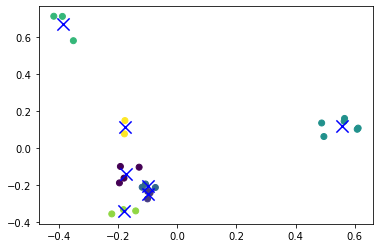

In [41]:
import spacy
from spacy import displacy
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

texts=read_files(folder)
texts=first_processing(texts)
texts=stemmer_text(texts)

intento=[]
for txt in texts:
    intento.append(' '.join(txt))

vectorizer = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)
matrix = vectorizer.fit_transform(intento)

cls = KMeans(n_clusters=7, random_state=1)
cls.fit(matrix)
cls.predict(matrix)

listing = os.listdir(folder)
df_labels=pd.DataFrame(listing)
df_labels['cluster']=cls.labels_
# reduce the features to 2D
pca = PCA(n_components=2, random_state=1)
reduced_features = pca.fit_transform(matrix.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
print(reduced_cluster_centers)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(matrix))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

from sklearn.decomposition import NMF
n_top_words = 15
feature_names = vectorizer.get_feature_names()
cls = NMF(n_components=7, random_state=1)
cls.fit(matrix)
for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

In [7]:
df_labels.sort_values('cluster').style.background_gradient()

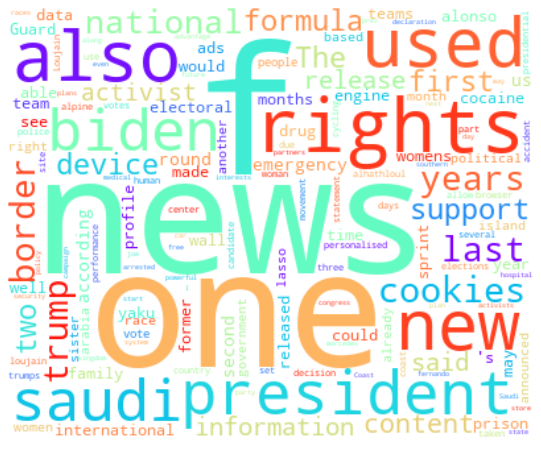

In [24]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

df_texts=get_term_matrix(texts)
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap='rainbow_r',background_color='white').generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  
# Transposing document term matrix
df_dtm=df_texts.T.sum(axis=1)

# Plotting word cloud for each product
generate_wordcloud(df_dtm.sort_values(ascending=False),'W')

<AxesSubplot:title={'center':'Most used words acros news'}>

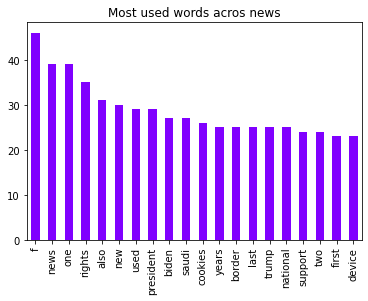

In [35]:
df_dtm.sort_values(ascending=False).head(20).plot(kind='bar',title='Most used words acros news',colormap='rainbow')

In [10]:
print("Prepared ", len(texts), " documents...")
print("They can be accessed using texts[0] - texts[" + str(len(texts)-1) + "]")

distanceFunction ="cosine"
#distanceFunction = "euclidean"
test = cluster_texts(texts,7,distanceFunction)
print("test: ", test)

# Gold Standard
# 0 activista Loujain
# 1 accidente Alonso
# 2 Muro frontera México
# 3 Icautación cocaína
# 4 Rescate cubanos
# 5 Gobierno de Italia
# 6 Elecciones Ecuador

reference =[0, 0, 1, 1, 1, 1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 3, 0, 0, 0, 4, 4, 0, 2, 2]
print("reference: ", reference)

# Evaluation
print("rand_score: ", adjusted_rand_score(reference,test))

Prepared  24  documents...
They can be accessed using texts[0] - texts[23]
Created a collection of 7602 terms.
Unique terms found:  2225
Vectors created.
test:  [1 1 0 0 0 0 4 3 5 2 2 2 6 6 6 3 1 1 1 5 5 1 4 4]
reference:  [0, 0, 1, 1, 1, 1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 3, 0, 0, 0, 4, 4, 0, 2, 2]
rand_score:  1.0
